# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

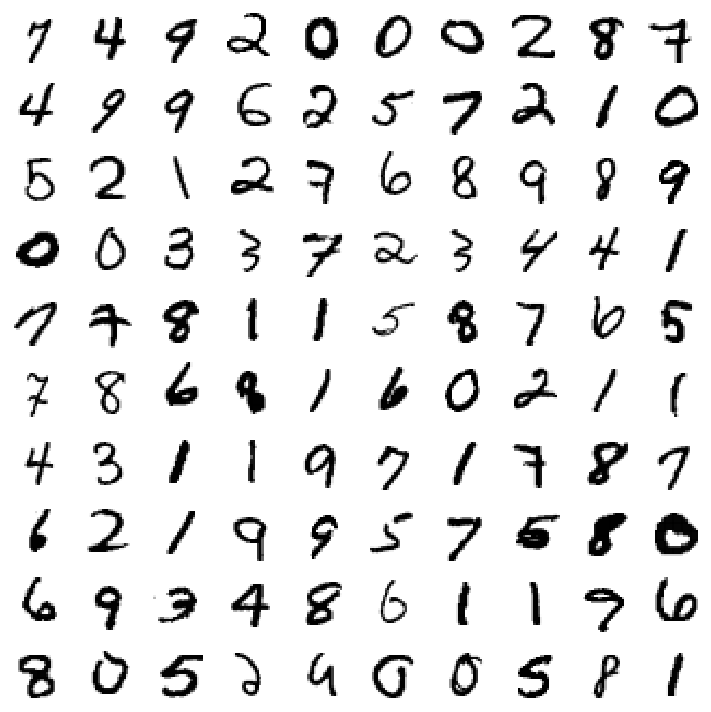

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model_MNIST = Sequential()
model_MNIST.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_MNIST.add(Conv2D(64, (3, 3), activation='relu'))
model_MNIST.add(MaxPooling2D(pool_size=(2, 2)))
model_MNIST.add(Dropout(0.25))
model_MNIST.add(Flatten())
model_MNIST.add(Dense(128, activation='relu'))
model_MNIST.add(Dropout(0.5))
model_MNIST.add(Dense(10, activation='softmax'))

model_MNIST.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Compile and train the network (note that this could take a while).

In [3]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model_MNIST.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

hist_1 = model_MNIST.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 20s 14ms/step - loss: 0.2433 - accuracy: 0.9265 - val_loss: 0.0564 - val_accuracy: 0.9810
Epoch 2/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0834 - accuracy: 0.9754 - val_loss: 0.0385 - val_accuracy: 0.9875
Epoch 3/12
469/469 [==============================] - 7s 16ms/step - loss: 0.0640 - accuracy: 0.9807 - val_loss: 0.0342 - val_accuracy: 0.9891
Epoch 4/12
469/469 [==============================] - 7s 14ms/step - loss: 0.0525 - accuracy: 0.9840 - val_loss: 0.0321 - val_accuracy: 0.9886
Epoch 5/12
469/469 [==============================] - 7s 14ms/step - loss: 0.0425 - accuracy: 0.9871 - val_loss: 0.0257 - val_accuracy: 0.9907
Epoch 6/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0386 - accuracy: 0.9879 - val_loss: 0.0265 - val_accuracy: 0.9908
Epoch 7/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0332 - accuracy: 0.9895 - val_loss: 0.0269 - val_accuracy: 0.990

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [4]:
score = model_MNIST.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02890264056622982
Test accuracy: 0.9926999807357788


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. The images corresponding to the DRIVE test set can be found [here](https://www.dropbox.com/s/zk51wgupimw7jd9/DRIVE.zip?dl=0).

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


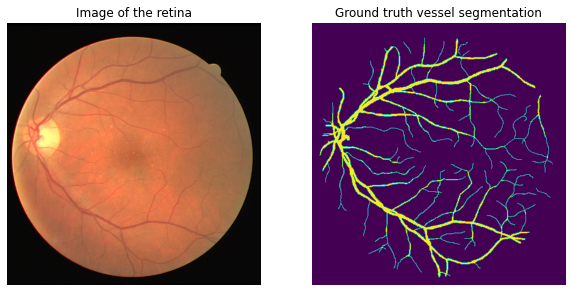

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 1
import sys
sys.path.append('./code/')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = './data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.png')

images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


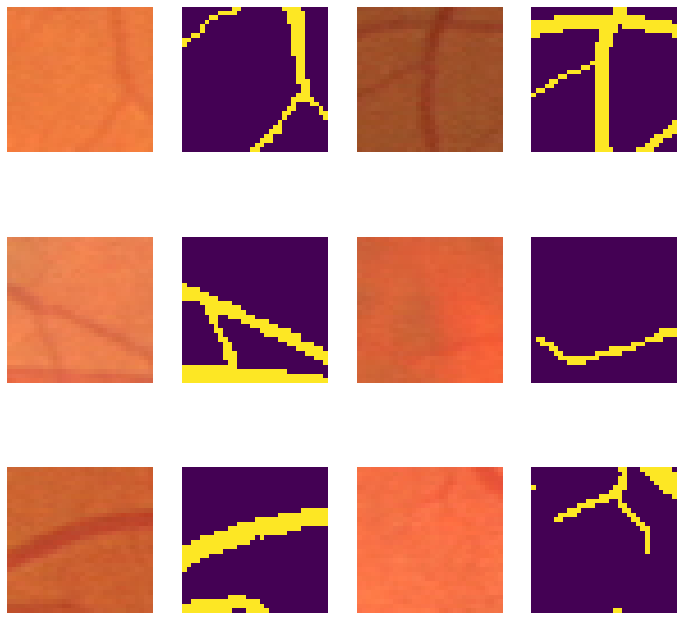

In [6]:
%reload_ext autoreload
%autoreload 1

from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [7]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [8]:
import os
from unet_model import unet
from unet_utils import datagenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 10
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/10
50/50 - 15s - loss: 0.5178 - accuracy: 0.8337 - val_loss: 0.4589 - val_accuracy: 0.9211
Epoch 2/10
50/50 - 2s - loss: 0.3168 - accuracy: 0.9447 - val_loss: 6.4465 - val_accuracy: 0.3865
Epoch 3/10
50/50 - 2s - loss: 0.2405 - accuracy: 0.9536 - val_loss: 20.3845 - val_accuracy: 0.1181
Epoch 4/10
50/50 - 2s - loss: 0.1697 - accuracy: 0.9607 - val_loss: 3.4710 - val_accuracy: 0.4493
Epoch 5/10
50/50 - 2s - loss: 0.1453 - accuracy: 0.9618 - val_loss: 0.2375 - val_accuracy: 0.9213
Epoch 6/10
50/50 - 2s - loss: 0.1649 - accuracy: 0.9544 - val_loss: 0.3206 - val_accuracy: 0.9222
Epoch 7/10
50/50 - 2s - loss: 0.1373 - accuracy: 0.9590 - val_loss: 0.3366 - val_accuracy: 0.9218
Epoch 8/10
50/50 - 2s - loss: 0.1250 - accuracy: 0.9607 - val_loss: 0.3271 - val_accuracy: 0.9239
Epoch 9/10
50/50 - 2s - loss: 0.1153 - accuracy: 0.9629 - val_loss: 0.1915 - val_accuracy: 0.9390
Epoch 10/10
50/50 - 2s - loss: 0.1130 - accuracy: 0.9618 - val_loss: 0.2365 - val_

### Visualizing the segmentation results

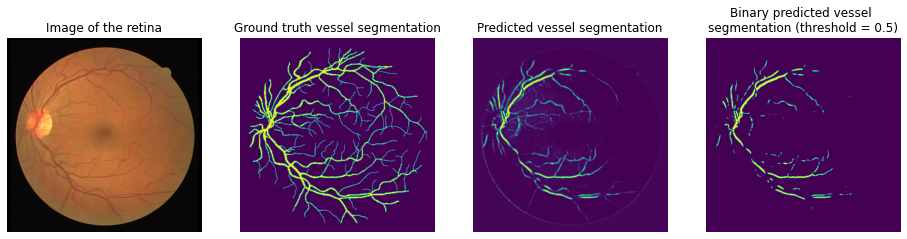

In [9]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.png')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations,
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(16, 10))

plt.subplot(1, 4, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 4, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 4, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.subplot(1, 4, 4)
plt.title("Binary predicted vessel \nsegmentation (threshold = 0.5)")
plt.axis('off')
plt.imshow((test_prediction[0, :, :, 0] > 0.5).astype(int))


plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1,179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

***ANSWER:*** The number of parameters corresponds to the number of weights between two layers of neurons, since these are the parameters that the model is optimizing. For a fully connected layer, all neurons in the first layer are connected to all neurons in the second layer (so, fully connected). A convolutional layer has shared weights, so, for each filter, there is a single kernel.

For a convolutional layer, the number of parameters can be described by the expression:

$$
\text{#params}_\text{Conv} = (\text{width}_\text{kernel} \cdot \text{height}_\text{kernel} \cdot \text{#filters}_\text{input layer}+1) * \text{#filters}_\text{output layer}
$$


For a fully-connected layer, this number can be described by the expression:

$$
\text{#params}_\text{FC} = (\text{#neurons}_\text{input layer} + 1) \cdot \text{#neurons}_\text{output layer} 
$$




## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

***ANSWER:***
As shown in the code below, this model consists of only convolutional layers, as well as pooling layers (but no fully-connected layers!). Furthermore, the output shape and the number of parameters are all the same in both models. When fitting the models to the same data they also show the same behaviour, as can be seen in the plots below. Both show a sharp initial increase in train accuracy and decrease in train loss, which both level out with the increasing epochs. For both models the validation accuracy is relatively high initially. Both models show a steady increase of validation accuracy and decrease of validation loss over the epochs. 

In [10]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model_MNIST1 = clone_model(model_MNIST)

model_MNIST2 = Sequential()
model_MNIST2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_MNIST2.add(Conv2D(64, (3, 3), activation='relu'))
model_MNIST2.add(MaxPooling2D(pool_size=(2, 2)))
model_MNIST2.add(Dropout(0.25))
model_MNIST2.add(Conv2D(128, (12,12), activation='relu'))
model_MNIST2.add(Dropout(0.5))
model_MNIST2.add(Conv2D(10, (1,1), activation='softmax'))
model_MNIST2.add(Flatten())

model_MNIST1.summary()
model_MNIST2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [11]:
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# Set random state, so that both models are trained the same way
tf.random.set_seed(2305)

# Load MNIST dataset (again)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Compile and fit both models
model_MNIST1.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model_MNIST2.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

hist_1 = model_MNIST1.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

hist_2 = model_MNIST2.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluate both models
score_1 = model_MNIST1.evaluate(x_test, y_test, verbose=0)
score_2 = model_MNIST2.evaluate(x_test, y_test, verbose=0)

print('{:15} {:20} {:20}'.format('','model 1', 'model 2'))
print('{:15} {:20} {:20}'.format('Test loss:', score_1[0], score_2[0]))
print('{:15} {:20} {:20}'.format('Test accuracy:', score_1[1], score_2[1]))


Epoch 1/12
469/469 [==============================] - 6s 13ms/step - loss: 0.2569 - accuracy: 0.9224 - val_loss: 0.0511 - val_accuracy: 0.9847
Epoch 2/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0915 - accuracy: 0.9730 - val_loss: 0.0395 - val_accuracy: 0.9877
Epoch 3/12
469/469 [==============================] - 6s 14ms/step - loss: 0.0687 - accuracy: 0.9794 - val_loss: 0.0364 - val_accuracy: 0.9883
Epoch 4/12
469/469 [==============================] - 6s 12ms/step - loss: 0.0556 - accuracy: 0.9826 - val_loss: 0.0312 - val_accuracy: 0.9900
Epoch 5/12
469/469 [==============================] - 6s 12ms/step - loss: 0.0476 - accuracy: 0.9853 - val_loss: 0.0327 - val_accuracy: 0.9896
Epoch 6/12
469/469 [==============================] - 7s 14ms/step - loss: 0.0428 - accuracy: 0.9865 - val_loss: 0.0311 - val_accuracy: 0.9895
Epoch 7/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0363 - accuracy: 0.9887 - val_loss: 0.0306 - val_accuracy: 0.9895

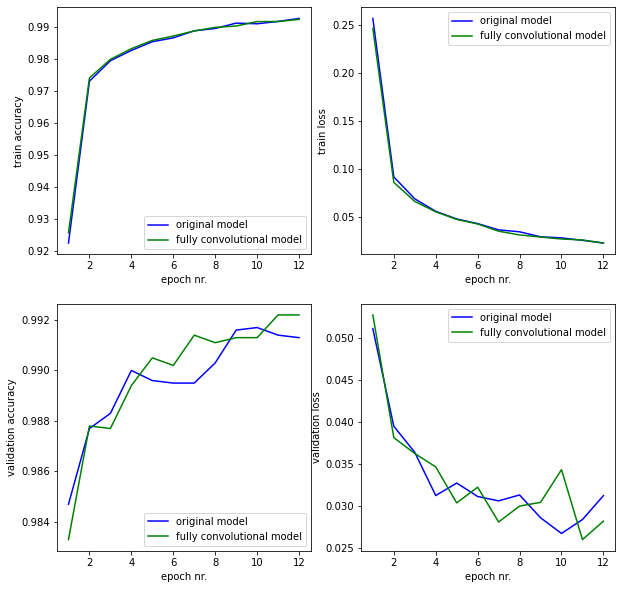

In [12]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10,10))
nr_epochs = range(1,13)

axs[0, 0].plot(nr_epochs, hist_1.history['accuracy'], 'b-', label='original model')
axs[0, 0].plot(nr_epochs, hist_2.history['accuracy'], 'g-', label='fully convolutional model')
axs[0, 0].set_ylabel("train accuracy")
axs[0, 0].set_xlabel("epoch nr.")
axs[0, 0].legend()

axs[0, 1].plot(nr_epochs, hist_1.history['loss'], 'b-', label='original model')
axs[0, 1].plot(nr_epochs, hist_2.history['loss'], 'g-', label='fully convolutional model')
axs[0, 1].set_ylabel("train loss")
axs[0, 1].set_xlabel("epoch nr.")
axs[0, 1].legend()

axs[1, 0].plot(nr_epochs, hist_1.history['val_accuracy'], 'b-', label='original model')
axs[1, 0].plot(nr_epochs, hist_2.history['val_accuracy'], 'g-', label='fully convolutional model')
axs[1, 0].set_ylabel("validation accuracy")
axs[1, 0].set_xlabel("epoch nr.")
axs[1, 0].legend()

axs[1, 1].plot(nr_epochs, hist_1.history['val_loss'], 'b-', label='original model')
axs[1, 1].plot(nr_epochs, hist_2.history['val_loss'], 'g-', label='fully convolutional model')
axs[1, 1].set_ylabel("validation loss")
axs[1, 1].set_xlabel("epoch nr.")
axs[1, 1].legend()



## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

***ANSWER:***
The original aim of the skip connections, as proposed by He et. al. with the introduction of their ResNet architectures in 2015 [1], was to circumvent the <i>vanishing gradient</i> problems and the <i>degradation</i> problem, where the accuracy becomes saturated as the depth of the network increases and then degrades swiftly. 

In the U-net architecture, the skip connections serve the same goal. However on top of that, the U-Net architecture employs them to include (localization) information from earlier on in the contraction path into the expansion path (which provides the contextual information). 

It would be possible to train the same network with the skip connections omitted. TensorFlow/Keras will certainly allow one to train such a network. However, there are problems that affect the training of the model.

There will be a lot of information missing from the contraction path, as the resolution is reduced greatly in the contaction path. Due to the reduced resolution, the images would be blurred in the expansion path. The result is that the expansion path will only provide the 'higher level' contextual information. The actual locations of objects would be lost in the resulting image. 

But not only the missing localisation information is a major problem when the skip connections are omitted. As mentioned above, the skip connections were originally introduced to circumvent the <i>vanishing gradients</i> problem. As U-Nets are generally deep networks, the vanishing gradient problem can become an issue. There is thus a chance that the gradients will vanish. In practice training will take a much longer time (perhaps even forever). 

In conclusion, skip connections will lead to poor performance as the result of the aforementioned problems.


[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep Residual Learning for Image
Recognition, 2015. 13, 14
https://arxiv.org/abs/1512.03385



## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

***ANSWER:*** Data augmentation generally results in less overfitting, since the model fits to a larger, more diverse dataset. The model is then less likely to learn features that are specific to the training set. Careful, advanced data augmentation can even in some cases approximate the addition of real training data [1] which beats any method as to prevention of overfitting. Applying data augmentation to the test set is not recommended, since it would result in testing on "fake" data, thus not returning valuable results.  

[2] Andreas  Steiner,  Alexander  Kolesnikov,  Xiaohua  Zhai,  Ross  Wightman,  Jakob  Uszkoreit,and Lucas Beyer.  How To train your ViT?  Data, Augmentation, and Regularization in Vision Transformers, 2021.  2, 17, 25
https://arxiv.org/abs/2106.10270


<font color='#770a0a'>Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above.</font>

<font color='#770a0a'> Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.</font>


In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('./code/')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from unet_utils import load_data, extract_patches, preprocessing, brightness_offset, datagenerator, bspline_brightness_offset, dice_coef
import os
from unet_model import unet
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# location of the DRIVE dataset
data_folder = './data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.png')

# Load data
images, masks, segmentations = load_data(train_paths)
print(masks.shape)

# Divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)
    
val_images,val_masks, val_segmentations = preprocessing(val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

# work with 32x32 patches and 200 patches per image
patch_size = (32, 32)
patches_per_im = 200

# Set hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 10

steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# create generator for patches
patch_data = datagenerator(train_images, train_segmentations, patch_size, patches_per_im=patches_per_im, batch_size=batch_size)

# define model (Unet)
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', dice_coef])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit(patch_data,
                          validation_data=(val_images, val_segmentations),
                          steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                          callbacks=[early_stopping])

(20, 584, 565, 1)
  ...
    to  
  ['...']
Train for 50 steps, validate on 4 samples
Epoch 1/10
50/50 [==============================] - 26s 530ms/step - loss: 0.5318 - accuracy: 0.7873 - dice_coef: 0.2945 - val_loss: 0.4695 - val_accuracy: 0.9211 - val_dice_coef: 0.1327
Epoch 2/10
50/50 [==============================] - 7s 150ms/step - loss: 0.3459 - accuracy: 0.9390 - dice_coef: 0.3346 - val_loss: 0.2721 - val_accuracy: 0.9211 - val_dice_coef: 0.0802
Epoch 3/10
50/50 [==============================] - 7s 148ms/step - loss: 0.2454 - accuracy: 0.9487 - dice_coef: 0.4254 - val_loss: 0.3089 - val_accuracy: 0.9211 - val_dice_coef: 0.0499
Epoch 4/10
50/50 [==============================] - 7s 148ms/step - loss: 0.1902 - accuracy: 0.9541 - dice_coef: 0.4960 - val_loss: 0.3071 - val_accuracy: 0.9208 - val_dice_coef: 0.0428
Epoch 5/10
50/50 [==============================] - 7s 149ms/step - loss: 0.1647 - accuracy: 0.9534 - dice_coef: 0.5397 - val_loss: 0.3627 - val_accuracy: 0.9211 - val_di

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\core\events.py", line 88, in trigger
    func(*args, **kwargs)
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\extensions\autoreload.py", line 538, in post_execute_hook
    _, pymtime = self._reloader.filename_and_mtime(sys.modules[modname])
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\extensions\autoreload.py", line 184, in filename_and_mtime
    if not hasattr(module, '__file__') or module.__file__ is None:
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\tensorflow\__init__.py", line 50, in __getattr__
    module = self._load()
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\tensorflow\__init__.py", line 44, in _load
    module = _importlib.import_module(self.__name__)
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._

In [ ]:
from tensorflow.keras.models import load_model, clone_model

# DATA AUGMENTATION USING BRIGHTNESS OFFSET
train_images_BO, train_masks_BO, train_segmentations_BO =  brightness_offset(train_images, train_masks, train_segmentations, [-0.1, 0.1], 30)
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images_BO)) / batch_size))

# create generator for patches
patch_data = datagenerator(train_images_BO, train_segmentations_BO, patch_size, patches_per_im=patches_per_im, batch_size=batch_size)

# copy the original model with random weights
model_BO = clone_model(model)

# compile model
model_BO.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', dice_coef])

# train the model with the data generator, and save the training history
history_BO = model_BO.fit(patch_data,
                          validation_data=(val_images, val_segmentations),
                          steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                          callbacks=[early_stopping])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 144 steps, validate on 4 samples
Epoch 1/10
144/144 [==============================] - 30s 208ms/step - loss: 0.3866 - accuracy: 0.8862 - dice_coef: 0.3375 - val_loss: 0.5457 - val_accuracy: 0.6635 - val_dice_coef: 0.0528
Epoch 2/10
144/144 [==============================] - 20s 138ms/step - loss: 0.1704 - accuracy: 0.9539 - dice_coef: 0.5351 - val_loss: 0.2720 - val_accuracy: 0.9215 - val_dice_coef: 0.0977
Epoch 3/10
144/144 [==============================] - 20s 138ms/step - loss: 0.1342 - accuracy: 0.9557 - dice_coef: 0.6141 - val_loss: 0.1845 - val_accuracy: 0.9426 - val_dice_coef: 0.4080
Epoch 4/10
144/144 [==============================] - 20s 138ms/step - loss: 0.1182 - accuracy: 0.9585 - dice_coef: 0.6484 - val_loss: 0.1098 - val_accuracy: 0.9634 - val_dice_coef: 0.6398
Epoch 5/10
144/144 [==============================] - 20s 139ms/step - loss: 0.1102 - accuracy: 0.9602 - dice_coef: 0.6624 - val_loss: 0.0999 - val_accuracy: 0.9651 - val_dice_coef: 0.6811
Epoch 6/10
1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <bound method AutoreloadMagics.post_execute_hook of <autoreload.AutoreloadMagics object at 0x00000184AF0A17F0>> (for post_execute):
Traceback (most recent call last):
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\core\events.py", line 88, in trigger
    func(*args, **kwargs)
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\extensions\autoreload.py", line 538, in post_execute_hook
    _, pymtime = self._reloader.filename_and_mtime(sys.modules[modname])
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\extensions\autoreload.py", line 184, in filename_and_mtime
    if not hasattr(module, '__file__') or module.__file__ is None:
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\tensorflow\__init__.py", line 50, in __getattr__
    module = self._load()
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\tensorflow\__init__.py", line 44, in _load
    module = _importlib.impo

In [ ]:
# DATA AUGMENTATION USING BRIGHTNESS OFFSET + BSPLINE
train_images_BO_BS, train_masks_BO_BS, train_segmentations_BO_BS =  bspline_brightness_offset(train_images, train_masks, train_segmentations, [-0.1, 0.1], 30)
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images_BO_BS)) / batch_size))

# create generator for patches
patch_data = datagenerator(train_images_BO_BS, train_segmentations_BO_BS, patch_size, patches_per_im=patches_per_im, batch_size=batch_size)

# copy the original model with random weights
model_BO_BS = clone_model(model)

# compile model
model_BO_BS.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', dice_coef])

# train the model with the data generator, and save the training history
history_BO_BS = model_BO_BS.fit(patch_data,
                          validation_data=(val_images, val_segmentations),
                          steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                          callbacks=[early_stopping])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 144 steps, validate on 4 samples
Epoch 1/10
144/144 - 27s - loss: 0.3575 - accuracy: 0.9055 - dice_coef: 0.3760 - val_loss: 0.2778 - val_accuracy: 0.9211 - val_dice_coef: 0.0700
Epoch 2/10
144/144 - 20s - loss: 0.1759 - accuracy: 0.9487 - dice_coef: 0.5524 - val_loss: 0.2707 - val_accuracy: 0.9213 - val_dice_coef: 0.0858
Epoch 3/10
144/144 - 20s - loss: 0.1460 - accuracy: 0.9496 - dice_coef: 0.6274 - val_loss: 0.2097 - val_accuracy: 0.9316 - val_dice_coef: 0.2858
Epoch 4/10
144/144 - 20s - loss: 0.1211 - accuracy: 0.9583 - dice_coef: 0.6305 - val_loss: 0.1360 - val_accuracy: 0.9544 - val_dice_coef: 0.5579
Epoch 5/10
144/144 - 20s - loss: 0.1232 - accuracy: 0.9554 - dice_coef: 0.6606 - val_loss: 0.0961 - val_accuracy: 0.9650 - val_dice_coef: 0.6562
Epoch 6/10
144/144 - 20s - loss: 0.1180 - accuracy: 0.9572 - dice_coef: 0.6696 - val_loss: 0.0995 - val_accuracy: 0.9628 - val_dice_coef: 0.6357
Epoch 7/10
144/144 - 20s - loss: 0.1152 - accuracy: 0.9576 - dice_coef: 0.6767 - val_lo

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <bound method AutoreloadMagics.post_execute_hook of <autoreload.AutoreloadMagics object at 0x00000184AF0A17F0>> (for post_execute):
Traceback (most recent call last):
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\core\events.py", line 88, in trigger
    func(*args, **kwargs)
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\extensions\autoreload.py", line 538, in post_execute_hook
    _, pymtime = self._reloader.filename_and_mtime(sys.modules[modname])
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\extensions\autoreload.py", line 184, in filename_and_mtime
    if not hasattr(module, '__file__') or module.__file__ is None:
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\tensorflow\__init__.py", line 50, in __getattr__
    module = self._load()
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\tensorflow\__init__.py", line 44, in _load
    module = _importlib.impo

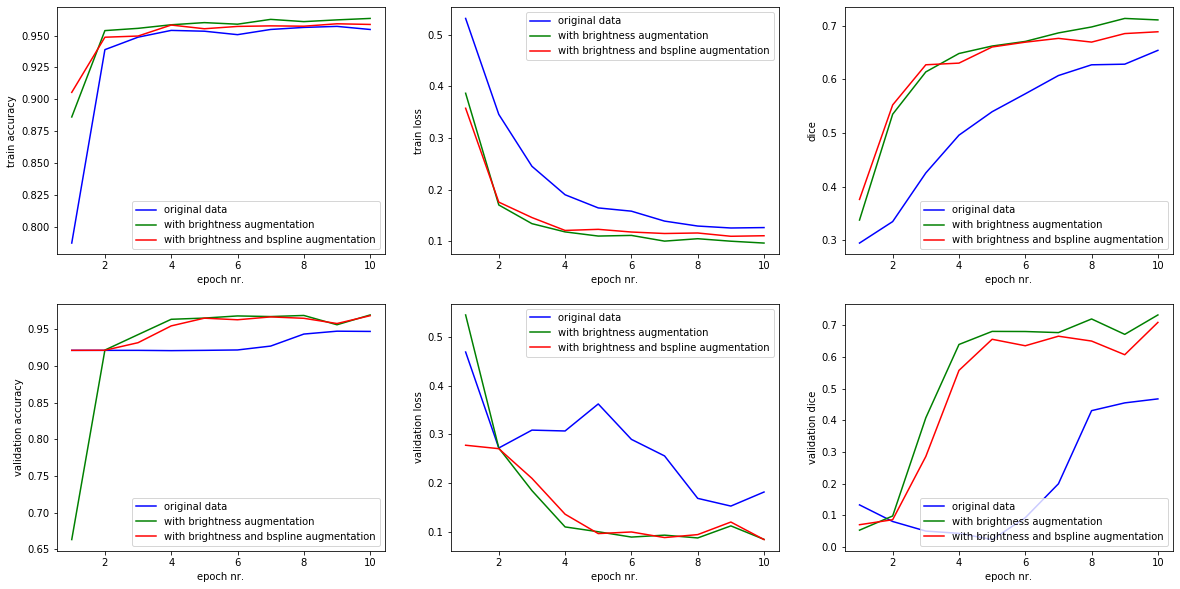

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <bound method AutoreloadMagics.post_execute_hook of <autoreload.AutoreloadMagics object at 0x00000184AF0A17F0>> (for post_execute):
Traceback (most recent call last):
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\core\events.py", line 88, in trigger
    func(*args, **kwargs)
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\extensions\autoreload.py", line 538, in post_execute_hook
    _, pymtime = self._reloader.filename_and_mtime(sys.modules[modname])
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\IPython\extensions\autoreload.py", line 184, in filename_and_mtime
    if not hasattr(module, '__file__') or module.__file__ is None:
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\tensorflow\__init__.py", line 50, in __getattr__
    module = self._load()
  File "C:\Users\20164798\Anaconda3\envs\8dm50\lib\site-packages\tensorflow\__init__.py", line 44, in _load
    module = _importlib.impo

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
nr_epochs = range(1,epochs+1)

axs[0, 0].plot(nr_epochs, history.history['accuracy'], 'b-', label='original data')
axs[0, 0].plot(nr_epochs, history_BO.history['accuracy'], 'g-', label='with brightness augmentation')
axs[0, 0].plot(nr_epochs, history_BO_BS.history['accuracy'], 'r-', label='with brightness and bspline augmentation')
axs[0, 0].set_ylabel("train accuracy")
axs[0, 0].set_xlabel("epoch nr.")
axs[0, 0].legend()

axs[0, 1].plot(nr_epochs, history.history['loss'], 'b-', label='original data')
axs[0, 1].plot(nr_epochs, history_BO.history['loss'], 'g-', label='with brightness augmentation')
axs[0, 1].plot(nr_epochs, history_BO_BS.history['loss'], 'r-', label='with brightness and bspline augmentation')
axs[0, 1].set_ylabel("train loss")
axs[0, 1].set_xlabel("epoch nr.")
axs[0, 1].legend()

axs[0, 2].plot(nr_epochs, history.history['dice_coef'], 'b-', label='original data')
axs[0, 2].plot(nr_epochs, history_BO.history['dice_coef'], 'g-', label='with brightness augmentation')
axs[0, 2].plot(nr_epochs, history_BO_BS.history['dice_coef'], 'r-', label='with brightness and bspline augmentation')
axs[0, 2].set_ylabel("dice")
axs[0, 2].set_xlabel("epoch nr.")
axs[0, 2].legend()

axs[1, 0].plot(nr_epochs, history.history['val_accuracy'], 'b-', label='original data')
axs[1, 0].plot(nr_epochs, history_BO.history['val_accuracy'], 'g-', label='with brightness augmentation')
axs[1, 0].plot(nr_epochs, history_BO_BS.history['val_accuracy'], 'r-', label='with brightness and bspline augmentation')
axs[1, 0].set_ylabel("validation accuracy")
axs[1, 0].set_xlabel("epoch nr.")
axs[1, 0].legend()

axs[1, 1].plot(nr_epochs, history.history['val_loss'], 'b-', label='original data')
axs[1, 1].plot(nr_epochs, history_BO.history['val_loss'], 'g-', label='with brightness augmentation')
axs[1, 1].plot(nr_epochs, history_BO_BS.history['val_loss'], 'r-', label='with brightness and bspline augmentation')
axs[1, 1].set_ylabel("validation loss")
axs[1, 1].set_xlabel("epoch nr.")
axs[1, 1].legend()

axs[1, 2].plot(nr_epochs, history.history['val_dice_coef'], 'b-', label='original data')
axs[1, 2].plot(nr_epochs, history_BO.history['val_dice_coef'], 'g-', label='with brightness augmentation')
axs[1, 2].plot(nr_epochs, history_BO_BS.history['val_dice_coef'], 'r-', label='with brightness and bspline augmentation')
axs[1, 2].set_ylabel("validation dice")
axs[1, 2].set_xlabel("epoch nr.")
axs[1, 2].legend()